In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

In [2]:
lat_start = 31.52
lon_start = -125.48
lat_end = 43.0
lon_end = -113.131

In [3]:
data = pd.read_csv('../data/NOAA_NARR_weather_data/california_box_air_sfc_2015_one_hour.csv') 
data.head()

,time,lat,lon,air
0,2015-03-23 18:00:00,31.63322,-125.3449,290.23242
1,2015-03-23 18:00:00,31.90358,-125.4247,290.23242
2,2015-03-23 18:00:00,31.70029,-125.0272,290.23242
3,2015-03-23 18:00:00,31.97103,-125.1057,290.04492
4,2015-03-23 18:00:00,32.24205,-125.1849,289.91992


In [4]:
# data coordinates and values
x = data['lon']
y = data['lat']
z = data['air']

# target grid to interpolate to
xi = np.arange(lon_start,lon_end,0.1)
yi = np.arange(lat_start,lat_end,0.1)
xi,yi = np.meshgrid(xi,yi)

In [5]:
type(xi)

numpy.ndarray

In [6]:
# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

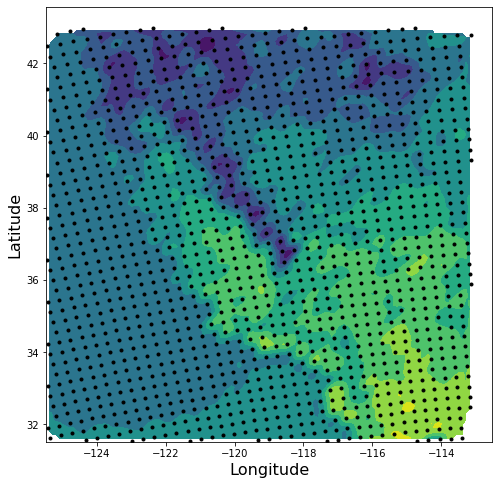

In [7]:
# plot
plt.rcParams["figure.figsize"] = (8,8)
plt.contourf(xi,yi,zi)
plt.plot(x,y,'k.')
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.show()

In [9]:
import geopandas as gpd
from geopandas import GeoSeries
import contextily as ctx
from pyproj import Proj, transform

In [10]:
from pyproj import Proj, transform

inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3857')
x2,y2 = transform(inProj,outProj,xi,yi)

<Figure size 576x576 with 0 Axes>

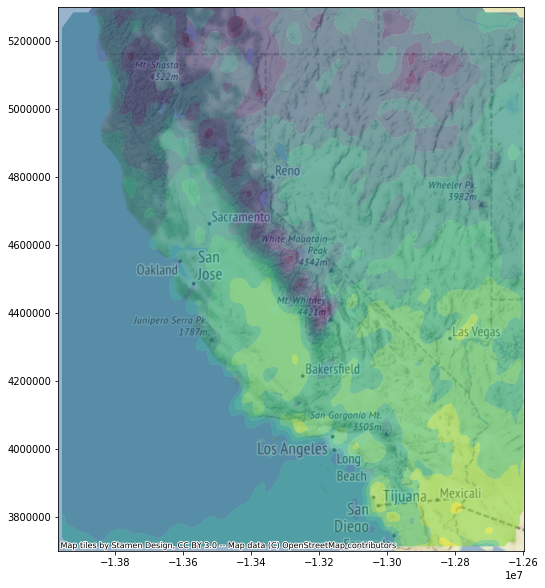

In [11]:
gdf = gpd.read_file('../data/spatial_data/cb_2018_us_state_500k.shp')
california = gdf[gdf['NAME'] == 'California']
california_3857 = california.to_crs(epsg=3857)

plt.rcParams["figure.figsize"] = (8,8)
fig = plt.figure() 
ax = california_3857.plot(figsize=(10, 10), alpha=0.0, edgecolor='k')
ax.contourf(x2,y2,zi, alpha=0.6, antialiased=True)
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=6)

In [12]:
import matplotlib.pyplot as plt 
from descartes import PolygonPatch

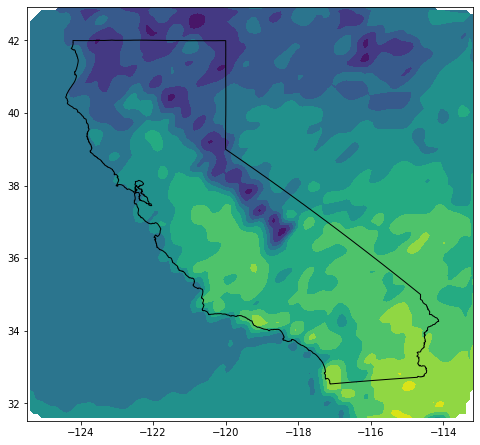

In [13]:
multipoly = california.loc[16, 'geometry']
california_land_mass = multipoly[-1]

plt.rcParams["figure.figsize"] = (8,8)
fig = plt.figure() 
ax = fig.gca() 
ax.add_patch(PolygonPatch(california_land_mass, fc='none', ec='black', zorder=2))
ax.contourf(xi,yi,zi)
ax.axis('scaled')
plt.show()